## MIS780 - Advanced Artificial Intelligence for Business

## Week 6 - Part 1: RNN for Univariate Time-Series Forecasting

This notebook demonstrates how to build a Recurrent Neural Network capable of forecasting stock price.


## Table of Content
   
1. [Initialisation ](#cell_Initialisation)
   
   
2. [Data Analysis](#cell_Preprocessing)     

    
4. [RNN Construction](#cell_RNN)    

    
4. [RNN Testing](#cell_RNN_Test)    



<a id = "cell_Initialisation"></a>
## 1. Initialisation

We first need to upload our data set `Mastercard_stock_price.csv` (available from Cloud Deakin) to Google Colab. Full description of the data set can be obtained from [Kaggle](https://www.kaggle.com/datasets/kalilurrahman/mastercard-stock-data-latest-and-updated?resource=download)

The project requires `Pandas` and `Numpy` for data manipulation, `Matplotlib.pyplot` for data visualization, `scikit-learn` for scaling and evaluation, and `TensorFlow` for modeling.

In [50]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)

<a id = "cell_Preprocessing"></a>
## 2.  Data Analysis

In this part, we will import the MasterCard dataset by adding the Date column to the index and converting it to DateTime format. We will also drop irrelevant columns from the dataset as we are only interested in stock prices, volume, and date.

In [51]:
dataset = pd.read_csv(
    'Mastercard_stock_price.csv', index_col='Date', parse_dates=["Date"]
    ).drop(["Dividends", "Stock Splits"], axis=1)
print(dataset.head())

                Open      High       Low     Close     Volume
Date                                                         
2006-05-25  3.748967  4.283869  3.739664  4.279217  395343000
2006-05-26  4.307126  4.348058  4.103398  4.179680  103044000
2006-05-30  4.183400  4.184330  3.986184  4.093164   49898000
2006-05-31  4.125723  4.219679  4.125723  4.180608   30002000
2006-06-01  4.179678  4.474572  4.176887  4.419686   62344000


The `.describe()` function helps us analyze the data in depth. Let's focus on the `High` column as we are going to use it to train the model.

In [52]:
print(dataset.describe())

              Open         High          Low        Close        Volume
count  3872.000000  3872.000000  3872.000000  3872.000000  3.872000e+03
mean    104.896814   105.956054   103.769349   104.882714  1.232250e+07
std     106.245511   107.303589   105.050064   106.168693  1.759665e+07
min       3.748967     4.102467     3.739664     4.083861  6.411000e+05
25%      22.347203    22.637997    22.034458    22.300391  3.529475e+06
50%      70.810079    71.375896    70.224002    70.856083  5.891750e+06
75%     147.688448   148.645373   146.822013   147.688438  1.319775e+07
max     392.653890   400.521479   389.747812   394.685730  3.953430e+08


Determine if there are missing values in the dataset

In [53]:
dataset.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Plots a simple line graph.

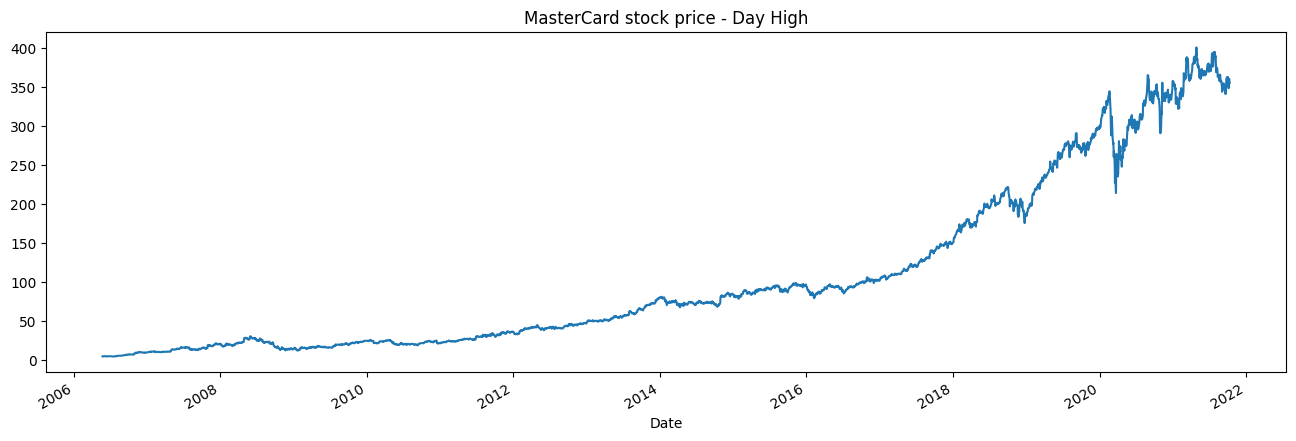

In [54]:
dataset['High'].plot(figsize=(16, 5))
plt.title("MasterCard stock price - Day High")
plt.show()

The `train_test_split` function divides the dataset into two subsets: `training_set` and `test_set`. We use data from 2016 to 2020 as training set, 2021 as test set. Historical data from 2006 to 2015 are considered old (useless for prediction) and thus discarded.

In [55]:
tstart = 2016
tend = 2020

def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"]
    test = dataset.loc[f"{tend+1}":, "High"]
    return train, test
training_set, test_set = train_test_split(dataset, tstart, tend)

Plot the training and test sets.

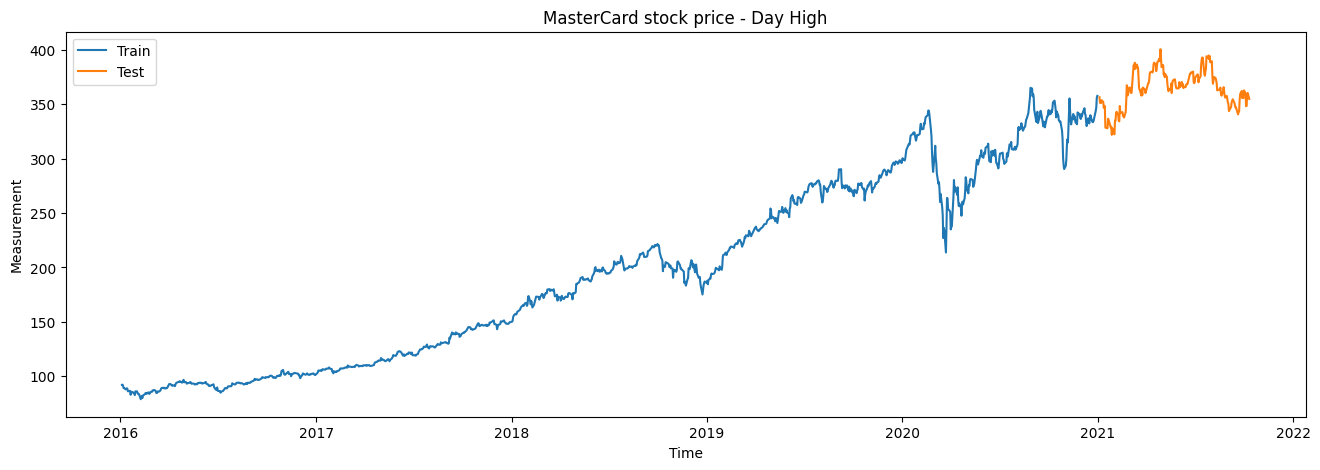

In [56]:
plt.figure(figsize=(16, 5))
plt.plot(training_set)
plt.plot(test_set)
plt.title('MasterCard stock price - Day High')
plt.ylabel('Measurement')
plt.xlabel('Time')
plt.legend(['Train', 'Test'], loc='upper left')

Use the `MinMaxScaler` function to standardize our training set, which will help us avoid the outliers or anomalies.

In [57]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.values.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

The `split_sequence` function uses a training dataset and converts it into inputs (`X_train`) and outputs (`y_train`).

For example, if the sequence is `[1,2,3,4,5,6,7,8,9,10,11,12]` and the `n_step` is `four` (*representing historical data used in forecasting*) and the `forecasting_horizon` is `two` (*representing the number of forecasting step ahead*), then it will convert the sequence into three input timestamps and one output as shown below:

| **x** | **y** |  
| --- | --- |
| 1, 2, 3, 4 | 5, 6 |  
| 2, 3, 4, 5 | 6, 7 |
| 3, 4, 5, 6 | 7, 8 |
| 4, 5, 6, 7 | 8, 9 |
| 5, 6, 7, 8 | 9, 10 |
| 6, 7, 8, 9 | 10, 11 |
| 7, 8, 9, 10 | 11, 12 |

In this exercise, we are using `n_steps=50` and `forecasting_horizon=7`. We aim to build a forecasting model capable of predicting stock price seven days ahead.

In [58]:
def split_sequence(sequence, n_steps,forecasting_horizon):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - forecasting_horizon:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+forecasting_horizon]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 50
forecasting_horizon = 7
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps,forecasting_horizon)

We are working with univariate series, so the number of features is one, and we need to reshape the `X_train` to fit on the RNN model. The `X_train` has `[samples, timesteps]`, and we will reshape it to `[samples, timesteps, features]`.

In [59]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

In [60]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (1203, 50, 1)
y_train shape: (1203, 7, 1)


Visualize one training sample.

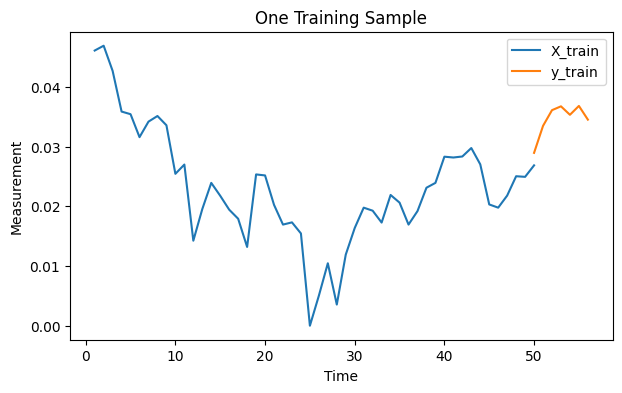

In [61]:
plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, n_steps+1, 1),X_train[0])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),y_train[0])
plt.title('One Training Sample')
plt.ylabel('Measurement')
plt.xlabel('Time')
plt.legend(['X_train', 'y_train'], loc='upper right')

<a id = "cell_RNN"></a>
## 3. RNN Training

The model consists of a single hidden layer of LSTM and an output layer. For this experiment, we will set LSTM units to 100, `tanh` as activation, and set input size.

Finally, we will compile the model with an `RMSprop` optimizer and mean square error as a loss function.

In [62]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=100, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=forecasting_horizon))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 7)                 707       
                                                                 
Total params: 41,507
Trainable params: 41,507
Non-trainable params: 0
_________________________________________________________________


The model will train on 100 epochs with 32 batch sizes. The `epochs` parameter specifies the number of times the model will iterate over the entire training dataset, and the `batch_size` parameter specifies the number of samples that will be used in each iteration.

In [63]:
model_lstm.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
38/38 [==============================] - 2s 7ms/step - loss: 0.0284
Epoch 2/100
38/38 [==============================] - 0s 5ms/step - loss: 0.0065
Epoch 3/100
38/38 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 4/100
38/38 [==============================] - 0s 5ms/step - loss: 0.0038
Epoch 5/100
38/38 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 6/100
38/38 [==============================] - 0s 5ms/step - loss: 0.0030
Epoch 7/100
38/38 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 8/100
38/38 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 9/100
38/38 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 10/100
38/38 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 11/100
38/38 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 12/100
38/38 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 13/100
38/38 [=================

<a id = "cell_RNN_test"></a>
## 4. RNN Testing

We are going to repeat preprocessing and normalize the test set. First of all we will transform then split the dataset into samples, reshape it, predict, and inverse transform the predictions into standard form.

In [71]:
#scaling
inputs = test_set.values.reshape(-1, 1)
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps,forecasting_horizon)

# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)

print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_test shape: (139, 50, 1)
y_test shape: (139, 7, 1)


In [72]:
#prediction
predicted_stock_price = model_lstm.predict(X_test)

#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print('predicted_stock_price shape: ', predicted_stock_price.shape)

#inverse transform the test labels.
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])
y_test = sc.inverse_transform(y_test)


5/5 [==============================] - 0s 4ms/step
predicted_stock_price shape:  (139, 7)


Next, we evaluate the prediction performance between the true and predicted values. Note, the forecasting peformance tend to decrease when predicting far away forecasting horizons.

In [73]:
def return_mae(test, predicted):
    mae = mean_absolute_error(test, predicted)
    print("Mean Absolute Error {:.2f}.".format(mae))

for i in range(forecasting_horizon):
  print("Forecasting Horizon: {} ".format(i))
  return_mae(y_test[:,i],predicted_stock_price[:,i])
  print("")

Forecasting Horizon: 0 
Mean Absolute Error 4.42.

Forecasting Horizon: 1 
Mean Absolute Error 5.95.

Forecasting Horizon: 2 
Mean Absolute Error 8.16.

Forecasting Horizon: 3 
Mean Absolute Error 7.51.

Forecasting Horizon: 4 
Mean Absolute Error 8.39.

Forecasting Horizon: 5 
Mean Absolute Error 8.59.

Forecasting Horizon: 6 
Mean Absolute Error 10.14.



Inverse transform the test data to orignal unit for visualization

In [74]:
X_test = X_test.reshape(-1, 50)
X_test = sc.inverse_transform(X_test)

Visualize the testing and predicted values of each testing time series segment.

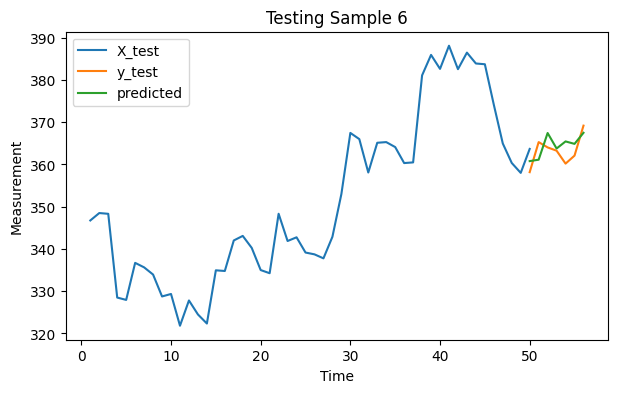

In [75]:
#Here we visualize the real vs. predicted values of the last testing segment.
sample_index = 6

plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, n_steps+1, 1),X_test[sample_index,:])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),y_test[sample_index,:])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),predicted_stock_price[sample_index,:])
plt.title('Testing Sample ' + str(sample_index))
plt.ylabel('Measurement')
plt.xlabel('Time')
plt.legend(['X_test', 'y_test', 'predicted'], loc='upper left')

Visualize all the real testing values versus the all predicted values based on each forecasting horizon.  

In [76]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Days Ahead")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()

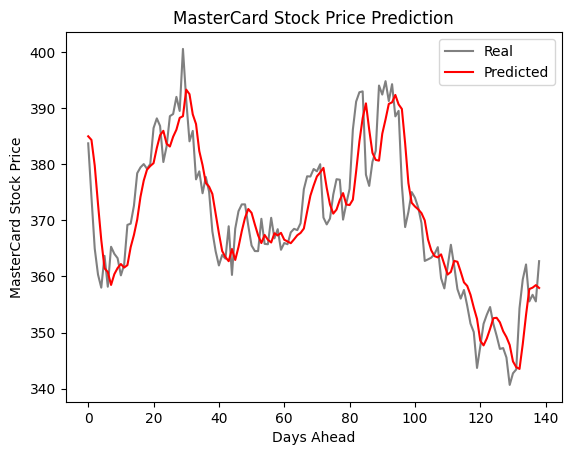

In [77]:
#Here we visualize the real vs. predicted values for one day forecasting horizon.
plot_predictions(y_test[:,0],predicted_stock_price[:,0])

### References:

***Adapted from:***<br>
*https://www.datacamp.com/tutorial/tutorial-for-recurrent-neural-network*
